<a id='summary'></a>
# Transition matrix by distance

## Summary
* [Loading GIS](#gis)


* [Making distance bins](#bins)
    * [Creating geometry of bins](#bin_geom)
    * [Cartesian product](#cart)
    * [adding the 'far' dist bin](#far)
    
    
* [Adding bin column to transition matrix](#add_col)
    * [Loading transition_matrices](#od)
    * [Adding intersection columns](#intersects)
    * [Exploding columns into distbin](#explode)
    * [Re-normalizing probas](#norm)


* [Exporting](#export)
* [Visualisation](#viz)

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt

from utils.chrono import Chrono

import os 
import json
with open('config.json', 'r') as config_path:
    config = json.load(config_path)
distbin_limits = config['distbin_limits']
dist_bins = [(distbin_limits[i], distbin_limits[i+1]) for i in range(len(distbin_limits)-1)]
dist_bins

[(0, 200),
 (200, 500),
 (500, 1000),
 (1000, 3000),
 (3000, 5000),
 (5000, 7000),
 (7000, 9000)]

<a id='gis'></a>
# Loading iris_communes
* [back to summary](#summary)

In [3]:
iris_commune_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['gis_map_filename'])

iris_commune = gpd.read_file(iris_commune_path)
iris_commune['iris_or_commune'] = iris_commune['iris_or_commune'].astype(int)
iris_commune['x'] = iris_commune['x'].astype(float)
iris_commune['y'] = iris_commune['y'].astype(float)
iris_commune.head()

,iris_or_commune,frac_area,is_iris,commune,x,y,nearest_neighbor_0,nearest_neighbor_1,nearest_neighbor_2,nearest_neighbor_3,...,nearest_neighbor_12,nearest_neighbor_13,nearest_neighbor_14,nearest_neighbor_15,nearest_neighbor_16,nearest_neighbor_17,nearest_neighbor_18,nearest_neighbor_19,wkt,geometry
0,1043,1.0,False,01043,3.932173e+06,2.538223e+06,692820201,692820103,692560101,692860101,...,692820601,01249,01276,01424,01262,01418,01049,01376,"POLYGON ((3931567.736276 2535603.293955, 39314...","POLYGON ((3931567.736 2535603.294, 3931455.673..."
1,1049,0.903,False,01049,3.934408e+06,2.538726e+06,692820103,692820201,01275,692750111,...,692820601,692790101,01424,01376,01418,01276,01043,01262,"POLYGON ((3931819.418597 2541777.410918, 39318...","POLYGON ((3931819.419 2541777.411, 3931843.795..."
2,1249,0.901,False,01249,3.927977e+06,2.538779e+06,692860102,69292,692860501,692860201,...,692860302,01043,692860303,692860304,01424,692860101,01376,01275,"POLYGON ((3930627.132465 2534580.112867, 39305...","POLYGON ((3930627.132 2534580.113, 3930588.941..."
3,1262,0.161,False,01262,3.934404e+06,2.540983e+06,692820201,692820204,692820104,692860101,...,692790101,01249,01418,01276,01376,01424,01043,01049,"POLYGON ((3931728.80375 2541776.576776, 393168...","POLYGON ((3931728.804 2541776.577, 3931683.836..."
4,1275,1.0,False,01275,3.926872e+06,2.536284e+06,692560202,01376,692860501,692560302,...,01249,692860401,692860301,692560101,692860302,692860101,692860304,692860303,"POLYGON ((3926169.735135 2534938.132562, 39260...","POLYGON ((3926169.735 2534938.133, 3926094.500..."


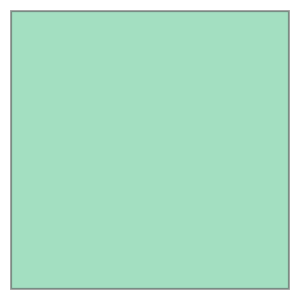

In [4]:
study_zone = iris_commune.dissolve()['geometry'].iloc[0].buffer(1)
study_zone

<a id='bins'></a>
# Making distance bins

<a id='bin_geom'></a>
## Creating geometry of bins
* [back to summary](#summary)

In [5]:

c=Chrono('Creating circles...')
for (rmin, rmax) in dist_bins:
    c.write('Creating circle {} <= r <= {}'.format(rmin, rmax))
    iris_commune['circle_{}_{}'.format(rmin, rmax)] = gpd.points_from_xy(iris_commune['x'], iris_commune['y']).buffer(rmax)

c.write('Creating circle {} <= r <= {}'.format(rmax, np.inf))
iris_commune['circle_{}_{}'.format(rmax, np.inf)] = study_zone.difference(iris_commune['circle_{}_{}'.format(rmin, rmax)])
dist_bins_with_inf = dist_bins + [(rmax, np.inf)]

i = len(dist_bins) - 2
for (rmin, rmax) in dist_bins[:0:-1]:
    c.write('Creating ring {} <= r <= {}'.format(rmin, rmax))
    iris_commune['circle_{}_{}'.format(rmin, rmax)] = (gpd.GeoSeries(iris_commune['circle_{}_{}'.format(rmin, rmax)])
                                     .difference(gpd.GeoSeries(iris_commune['circle_{}_{}'.format(*dist_bins[i])])))
    i -= 1

c.done()

12:57:33	Creating circles...
00:00:00	Creating circle 0 <= r <= 200
00:00:00	Creating circle 200 <= r <= 500
00:00:00	Creating circle 500 <= r <= 1000
00:00:00	Creating circle 1000 <= r <= 3000
00:00:00	Creating circle 3000 <= r <= 5000
00:00:00	Creating circle 5000 <= r <= 7000
00:00:00	Creating circle 7000 <= r <= 9000
00:00:00	Creating circle 9000 <= r <= inf
00:00:00	Creating ring 7000 <= r <= 9000
00:00:00	Creating ring 5000 <= r <= 7000
00:00:00	Creating ring 3000 <= r <= 5000
00:00:00	Creating ring 1000 <= r <= 3000
00:00:00	Creating ring 500 <= r <= 1000
00:00:00	Creating ring 200 <= r <= 500
00:00:00	Work complete !


<a id='cart'></a>
## Cartesian product of GIS
* [back to summary](#summary)

In [6]:
iris_commune['cart_key'] = 1
gis_couples = pd.DataFrame(iris_commune[['iris_or_commune', 'cart_key'] +
                          ['circle_{}_{}'.format(rmin, rmax) for rmin, rmax in dist_bins_with_inf]]).merge(
    iris_commune[['iris_or_commune', 'geometry', 'cart_key']], on='cart_key')

In [7]:
c = Chrono('Adding column of whether O and D intersect...')
for (rmin, rmax) in dist_bins_with_inf:
    gis_couples['intersect_{}_{}'.format(rmin, rmax)] = gpd.GeoSeries(gis_couples['circle_{}_{}'.format(rmin, rmax)]).intersects(gpd.GeoSeries(gis_couples['geometry']))
c.done()

12:57:35	Adding column of whether O and D intersect...
00:00:30	Work complete !


## cleaning

In [8]:
# keep a copy for viz
gis_couples_viz = gis_couples.copy()

In [9]:
gis_couples = gis_couples[['iris_or_commune_x', 'iris_or_commune_y'] + 
                           ['intersect_{}_{}'.format(rmin, rmax) for rmin, rmax in dist_bins_with_inf]]
gis_couples = gis_couples.rename(columns={'iris_or_commune_x':'o', 'iris_or_commune_y':'d'})
gis_couples

,o,d,intersect_0_200,intersect_200_500,intersect_500_1000,intersect_1000_3000,intersect_3000_5000,intersect_5000_7000,intersect_7000_9000,intersect_9000_inf
0,1043,1043,True,True,True,True,True,False,False,False
1,1043,1049,False,False,False,True,True,False,False,False
2,1043,1249,False,False,False,True,True,True,True,False
3,1043,1262,False,False,False,True,True,True,False,False
4,1043,1275,False,False,False,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...
289439,693890303,693890201,False,False,True,True,True,False,False,False
289440,693890303,693890607,False,False,False,True,False,False,False,False
289441,693890303,693890301,True,True,True,False,False,False,False,False
289442,693890303,693890203,False,False,True,True,False,False,False,False


## Simplified version of intersection
* Just bins the centroid distances
* Overrides the previous version of intersection

In [10]:
iris_commune['cart_key'] = 1
gis_couples = pd.DataFrame(iris_commune[['iris_or_commune', 'cart_key','x','y']].merge(
                           iris_commune[['iris_or_commune', 'geometry', 'cart_key','x','y']], 
                           on='cart_key', suffixes=('_o','_d')))

gis_couples['centroid_dist'] = np.sqrt((gis_couples['x_o']-gis_couples['x_d'])**2 + 
                                       (gis_couples['y_o']-gis_couples['y_d'])**2)

for (rmin, rmax) in dist_bins_with_inf:
    gis_couples['intersect_{}_{}'.format(rmin, rmax)] = (rmin<=gis_couples['centroid_dist'])&(gis_couples['centroid_dist']<rmax)
    
gis_couples = gis_couples.rename(columns={'iris_or_commune_o':'o', 'iris_or_commune_d':'d'})
gis_couples.sample(5)

,o,cart_key,x_o,y_o,d,geometry,x_d,y_d,centroid_dist,intersect_0_200,intersect_200_500,intersect_500_1000,intersect_1000_3000,intersect_3000_5000,intersect_5000_7000,intersect_7000_9000,intersect_9000_inf
238724,693850204,1,3.917584e+06,2.529947e+06,693830205,"POLYGON ((3920342.708 2529858.498, 3920347.235...",3.920182e+06,2.530028e+06,2599.163267,False,False,False,True,False,False,False,False
253787,693870601,1,3.918778e+06,2.528175e+06,693830105,"POLYGON ((3919741.057 2530192.474, 3919748.967...",3.919489e+06,2.530095e+06,2047.917021,False,False,False,True,False,False,False,False
109741,692590401,1,3.920613e+06,2.523002e+06,693890606,"POLYGON ((3916090.163 2533368.005, 3916495.503...",3.916120e+06,2.533013e+06,10972.964010,False,False,False,False,False,False,False,True
212334,693830401,1,3.921101e+06,2.530262e+06,693810301,"POLYGON ((3918945.719 2531923.592, 3918945.580...",3.918814e+06,2.531716e+06,2710.085692,False,False,False,True,False,False,False,False
129725,692660502,1,3.922664e+06,2.532229e+06,690290101,"POLYGON ((3924565.080 2528912.263, 3924526.383...",3.923963e+06,2.528219e+06,4215.828349,False,False,False,False,True,False,False,False


<a id='add_col'></a>
# Adding the `dist_bin` column to transition matrix
* [back to summary](#summary)

<a id='od'></a>
## Loading transition matrix
* [back to summary](#summary)

In [12]:
c = Chrono('Loading...')
transition_matrix_path = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['transition_matrix_filename'])
transition_matrix = pd.read_csv(transition_matrix_path)
timesteps = np.array([ 0.,  2.,  5.,  7.,  8.,  9., 10., 12., 14., 16., 17., 18., 19., 20., 22.])

c.tprint('Snapping the individual hours to timesteps...')
transition_matrix['t'] = timesteps[np.maximum(np.searchsorted(timesteps, transition_matrix['t'], side='right')-1, 0)]
transition_matrix = transition_matrix.groupby(['o','d','t']).sum().reset_index()

c.done()
transition_matrix.head()


15:19:24	Loading...
00:00:01	Snapping the individual hours to timesteps...
00:00:02	Work complete !


,o,d,t,vol,proba_d,proba_o
0,1043,1043,0.0,9.132230,0.287785,0.205852
1,1043,1043,2.0,5.813602,0.271967,0.123532
2,1043,1043,5.0,17.833213,0.105533,0.124070
3,1043,1043,7.0,54.360548,0.193669,0.187093
4,1043,1043,8.0,29.113536,0.120248,0.102542


<a id='intersects'></a>
## Adding columns of bin intersections
* [back to summary](#summary)

In [13]:
transition_matrix = transition_matrix.merge(gis_couples, on=['o', 'd'])
transition_matrix

,o,d,t,vol,proba_d,proba_o,cart_key,x_o,y_o,geometry,...,y_d,centroid_dist,intersect_0_200,intersect_200_500,intersect_500_1000,intersect_1000_3000,intersect_3000_5000,intersect_5000_7000,intersect_7000_9000,intersect_9000_inf
0,1043,1043,0.0,9.132230,0.287785,0.205852,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",...,2.538223e+06,0.0,True,False,False,False,False,False,False,False
1,1043,1043,2.0,5.813602,0.271967,0.123532,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",...,2.538223e+06,0.0,True,False,False,False,False,False,False,False
2,1043,1043,5.0,17.833213,0.105533,0.124070,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",...,2.538223e+06,0.0,True,False,False,False,False,False,False,False
3,1043,1043,7.0,54.360548,0.193669,0.187093,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",...,2.538223e+06,0.0,True,False,False,False,False,False,False,False
4,1043,1043,8.0,29.113536,0.120248,0.102542,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",...,2.538223e+06,0.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274784,693890607,693890607,17.0,26.632656,0.060311,0.067584,1,3.915862e+06,2.533234e+06,"POLYGON ((3915846.624 2533492.240, 3915853.448...",...,2.533234e+06,0.0,True,False,False,False,False,False,False,False
2274785,693890607,693890607,18.0,31.894093,0.070294,0.086901,1,3.915862e+06,2.533234e+06,"POLYGON ((3915846.624 2533492.240, 3915853.448...",...,2.533234e+06,0.0,True,False,False,False,False,False,False,False
2274786,693890607,693890607,19.0,23.694785,0.062325,0.088538,1,3.915862e+06,2.533234e+06,"POLYGON ((3915846.624 2533492.240, 3915853.448...",...,2.533234e+06,0.0,True,False,False,False,False,False,False,False
2274787,693890607,693890607,20.0,30.119790,0.087407,0.108340,1,3.915862e+06,2.533234e+06,"POLYGON ((3915846.624 2533492.240, 3915853.448...",...,2.533234e+06,0.0,True,False,False,False,False,False,False,False


<a id='explode'></a>
## Exploding intersection columns into `dist_bin`
* [back to summary](#summary)

In [14]:
transition_matrix_by_dist = pd.DataFrame()
for (rmin, rmax) in dist_bins_with_inf:
    transition_matrix_bin = transition_matrix[transition_matrix['intersect_{}_{}'.format(rmin, rmax)]].copy()
    transition_matrix_bin['dist_bin_min'] = rmin
    transition_matrix_bin['dist_bin_max'] = rmax
    transition_matrix_by_dist = pd.concat([transition_matrix_by_dist, transition_matrix_bin])

In [15]:
transition_matrix_by_dist = transition_matrix_by_dist.drop(columns=['intersect_{}_{}'.format(rmin, rmax) for (rmin, rmax) in dist_bins_with_inf])
transition_matrix_by_dist

,o,d,t,vol,proba_d,proba_o,cart_key,x_o,y_o,geometry,x_d,y_d,centroid_dist,dist_bin_min,dist_bin_max
0,1043,1043,0.0,9.132230,0.287785,0.205852,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",3.932173e+06,2.538223e+06,0.000000,0,200.0
1,1043,1043,2.0,5.813602,0.271967,0.123532,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",3.932173e+06,2.538223e+06,0.000000,0,200.0
2,1043,1043,5.0,17.833213,0.105533,0.124070,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",3.932173e+06,2.538223e+06,0.000000,0,200.0
3,1043,1043,7.0,54.360548,0.193669,0.187093,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",3.932173e+06,2.538223e+06,0.000000,0,200.0
4,1043,1043,8.0,29.113536,0.120248,0.102542,1,3.932173e+06,2.538223e+06,"POLYGON ((3931567.736 2535603.294, 3931455.673...",3.932173e+06,2.538223e+06,0.000000,0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274388,693890607,693880503,10.0,0.238870,0.000390,0.001481,1,3.915862e+06,2.533234e+06,"POLYGON ((3921811.062 2526021.405, 3921720.841...",3.922007e+06,2.526355e+06,9223.680316,9000,inf
2274389,693890607,693880503,12.0,0.076451,0.000105,0.000460,1,3.915862e+06,2.533234e+06,"POLYGON ((3921811.062 2526021.405, 3921720.841...",3.922007e+06,2.526355e+06,9223.680316,9000,inf
2274390,693890607,693880503,16.0,0.031676,0.000081,0.000281,1,3.915862e+06,2.533234e+06,"POLYGON ((3921811.062 2526021.405, 3921720.841...",3.922007e+06,2.526355e+06,9223.680316,9000,inf
2274391,693890607,693880503,17.0,0.413712,0.000937,0.002742,1,3.915862e+06,2.533234e+06,"POLYGON ((3921811.062 2526021.405, 3921720.841...",3.922007e+06,2.526355e+06,9223.680316,9000,inf


<a id='norm'></a>
## Re-normalizing `proba_d`
* [back to summary](#summary)

In [16]:
transition_matrix_by_dist['proba_d_total'] = transition_matrix_by_dist.groupby(['o', 't', 'dist_bin_min', 'dist_bin_max'])['proba_d'].transform(sum)
transition_matrix_by_dist['proba_d'] = transition_matrix_by_dist['proba_d']/transition_matrix_by_dist['proba_d_total']
transition_matrix_by_dist = transition_matrix_by_dist.drop(columns=['proba_d_total'])

In [17]:
transition_matrix_by_dist = transition_matrix_by_dist.drop(columns='proba_o')

<a id='export'></a>
# Exporting
* [back to summary](#summary)

In [18]:
transition_matrix_by_dist_outpath = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['transition_matrix_by_dist_filename'])

transition_matrix_by_dist.to_csv(transition_matrix_by_dist_outpath, index=False)

# # Reading example
# import pandas as pd
# transition_matrix_path = os.path.join(config['outdata_dir']['path'], 
#                                      config['outdata_dir']['transition_matrix_by_dist_filename'])
# transition_matrix_by_dist = pd.read_csv(transition_matrix_path)
# transition_matrix_by_dist.head()

<a id='viz'></a>
# Viz
* [back to summary](#summary)

## distribution of distances

In [19]:
trans_matrix = transition_matrix_by_dist

c=Chrono('Adding dist_bin column to transition matrix...')

bin_replace_dict = {rmin:i for i, (rmin, rmax) in enumerate(dist_bins_with_inf)}
trans_matrix['dist_bin'] = trans_matrix['dist_bin_min'].replace(bin_replace_dict)


synthpop_path = '../../outdata/synthpop/synthpop_statmatch_rescaleipu.csv'
c.write('Loading agents...')
synthpop = pd.read_csv(synthpop_path)
c.write('{} rows, 1 row per agents'.format(len(synthpop)))

max_chain_len = synthpop['chain_len'].max()
c.tprint('max_chain_len = {}'.format(max_chain_len))

c.write('adding dist bin...')
for i in range(1, max_chain_len+1):
    synthpop['dep_{}_dist_bin'.format(i)] = pd.cut(synthpop['dep_{}_l2'.format(i)], 
                                                  bins=[rmin for rmin, rmax in dist_bins_with_inf]+[np.inf], 
                                                  labels=range(len(dist_bins_with_inf))).astype(float)
c.done()

15:22:11	Adding dist_bin column to transition matrix...
00:00:00	Loading agents...
00:00:09	1375987 rows, 1 row per agents
00:00:09	max_chain_len = 10
00:00:09	adding dist bin...
00:00:09	Work complete !


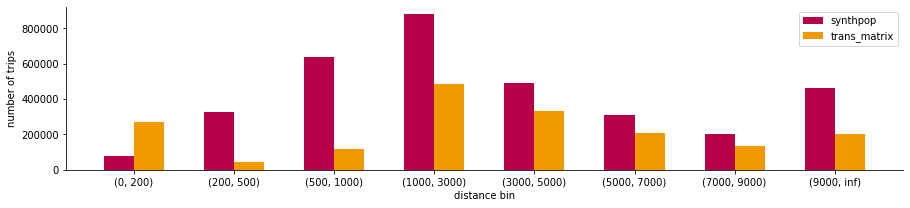

In [21]:
color_dict = {
    'synthpop' : (182/255,0/255,74/255),
    'trans_matrix' : (241/255, 154/255, 0/255),
}

def comp_bar(ax, width=0.2, **bars):
    nbars = len(bars)
    ibar = 0
    for label, bar in bars.items():
        barplot = ax.bar(np.arange(len(bar))-(nbars-1)*width/2 + width*ibar, 
                      bar, 
                      width=width, label=label, color=color_dict[label])
        ibar+=1
    
    ax.legend()
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
fig, ax = plt.subplots(figsize=(15, 3))

synthpop_bin_counts = (pd.concat([synthpop.groupby('dep_{}_dist_bin'.format(i)).size() 
                                  for i in range(1, max_chain_len+1)])
                       .reset_index().groupby('index').sum())

trans_matrix_bin_counts = trans_matrix.groupby('dist_bin')['vol'].sum()
comp_bar(ax, width=0.3, synthpop = synthpop_bin_counts[0], trans_matrix=trans_matrix_bin_counts)
ax.set_xticks(np.arange(len(trans_matrix_bin_counts)), dist_bins_with_inf)
ax.set_xlabel('distance bin')
ax.set_ylabel('number of trips')
plt.show()

## maps of candidates wrt distance bin

In [ ]:
#import contextily as ctx


In [ ]:
gis_couples

In [ ]:
green = (146/255, 208/255, 80/255)
blue = (0/255, 176/255, 240/255)

fig, ax = plt.subplots(figsize=(10,10))
#target_o = 693820201
target_o= 693810304.0
iris_commune.boundary.plot(ax=ax, color='k', linewidth=0.5)

rmin, rmax = dist_bins[0]

gpd.GeoSeries(gis_couples_viz.loc[(gis_couples['o']==target_o) & 
                (gis_couples['intersect_{}_{}'.format(rmin, rmax)]), 'geometry']).plot(ax=ax, color=blue, alpha=0.7)

iris_commune.loc[iris_commune['iris_or_commune']==target_o,
                 'circle_{}_{}'.format(rmin, rmax)].plot(ax=ax, color=green)
iris_commune[iris_commune['iris_or_commune']==target_o].plot(ax=ax, color='r')

ax.axis('off')
#ax.set_xlim(3.915e6, 3.925e6)
#ax.set_ylim(2.525e6, 2.535e6)
ax.set_title('bin {}m -> {}m'.format(rmin, rmax))
plt.show()

In [ ]:
green = (146/255, 208/255, 80/255)
blue = (0/255, 176/255, 240/255)
target_o = 693820201


fig, axes = plt.subplots(1, len(dist_bins_with_inf), figsize=(10*len(dist_bins_with_inf),10))
for i in range(len(dist_bins_with_inf)):
    ax = axes[i]
    iris_commune.boundary.plot(ax=ax, color='k', linewidth=0.5)
    
    rmin, rmax = dist_bins_with_inf[i]
    
    gpd.GeoSeries(gis_couples_viz.loc[(gis_couples['o']==target_o) & 
                    (gis_couples['intersect_{}_{}'.format(rmin, rmax)]), 'geometry']).plot(ax=ax, color=blue, alpha=0.7)
    
    iris_commune.loc[iris_commune['iris_or_commune']==target_o,
                     'circle_{}_{}'.format(rmin, rmax)].plot(ax=ax, color=green)
    iris_commune[iris_commune['iris_or_commune']==target_o].plot(ax=ax, color='r')

    ax.axis('off')
    ax.set_xlim(3.915e6, 3.925e6)
    ax.set_ylim(2.525e6, 2.535e6)
    ax.set_title('bin {}m -> {}m'.format(rmin, rmax), fontsize='xx-large')
plt.show()

In [ ]:
green = (146/255, 208/255, 80/255)
blue = (0/255, 176/255, 240/255)
target_o = 693820201

subbins = np.arange(2,5)

fig, axes = plt.subplots(1, len(subbins), figsize=(10*len(subbins),10))
for axei, i in enumerate(subbins):
    ax = axes[axei]
    iris_commune.boundary.plot(ax=ax, color='k', linewidth=0.5)
    
    rmin, rmax = dist_bins_with_inf[i]
    
    gpd.GeoSeries(gis_couples_viz.loc[(gis_couples['o']==target_o) & 
                    (gis_couples['intersect_{}_{}'.format(rmin, rmax)]), 'geometry']).plot(ax=ax, color=blue, alpha=0.7)
    
    iris_commune.loc[iris_commune['iris_or_commune']==target_o,
                     'circle_{}_{}'.format(rmin, rmax)].plot(ax=ax, color=green)
    iris_commune[iris_commune['iris_or_commune']==target_o].plot(ax=ax, color='r')

    ax.axis('off')
    ax.set_xlim(3.915e6, 3.925e6)
    ax.set_ylim(2.525e6, 2.535e6)
    ax.set_title('bin {}m -> {}m'.format(rmin, rmax), fontsize='xx-large')
    
plt.savefig('/Users/benoit/Desktop/dist_bins.pdf')
plt.show()

In [ ]:
study_zone.bounds

In [ ]:
green = (168/255, 243/255, 90/255)
blue = (0/255, 176/255, 240/255)
red = (216/255, 27/255, 96/255)
target_o = 693820201

figsize = 5
nb_rows = int(np.ceil(len(dist_bins_with_inf)/2))
fig, axes = plt.subplots(nb_rows, 2, figsize=(2*figsize, nb_rows*figsize))

for i in range(len(dist_bins_with_inf)):
    ax = axes[i//2, i%2]
    #iris_commune.boundary.plot(ax=ax, color='k', linewidth=0.1)
    iris_commune.boundary.plot(ax=ax, color='k', alpha=0.1, linewidth=0.5)
    rmin, rmax = dist_bins_with_inf[i]
    
    gpd.GeoSeries(gis_couples_viz.loc[(gis_couples['o']==target_o) & 
                    (gis_couples['intersect_{}_{}'.format(rmin, rmax)]), 'geometry']).plot(ax=ax, color=blue, alpha=0.7)
    
    iris_commune.loc[iris_commune['iris_or_commune']==target_o,
                     'circle_{}_{}'.format(rmin, rmax)].intersection(study_zone).plot(ax=ax, color=green)
    iris_commune[iris_commune['iris_or_commune']==target_o].plot(ax=ax, color=red)

    ax.axis('off')
    if i<4:
        ax.set_xlim(3.915e6, 3.925e6)
        ax.set_ylim(2.525e6, 2.535e6)
    else:
        ax.set_xlim(study_zone.bounds[0], study_zone.bounds[2])
        ax.set_ylim(study_zone.bounds[1], study_zone.bounds[3])
    
    if i==len(dist_bins_with_inf)-1:
        ax.set_title('bin {}m -> {}'.format(rmin, rmax), fontsize='x-large', font='helvetica')
    else:
        ax.set_title('bin {}m -> {}m'.format(rmin, rmax), fontsize='x-large', font='helvetica')
    
#plt.tight_layout()
plt.savefig('/Users/benoit/Desktop/length_bins.pdf', bbox_inches='tight')

plt.show()